In [4]:
# Loading in libraries
import pandas as pd
import matplotlib.pyplot as plt
import spatial_efd
import math 
import signac
import numpy as np
import os.path
import os
import torch
import gpytorch
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import similaritymeasures
#from smt.sampling_methods import LHS
# Importing helper libraries for bayesian optimization
from dependencies.data_preprocessing_class import dataPreprocessing
from dependencies.gaussian_process_regression_class import gaussianProcessRegression
from dependencies.acquisition_functions_class import acqisitionFunctions
from dependencies.geometry_writer import geometryWriter
from dependencies.feature_extractor_4 import FeatureExtractor


In [5]:
# Checking if data exists
doesDataFileExist = os.path.isfile("master_feature_output.npy")
# Loading datafiles if they exist
# Else fetching and preparing data from signac workspace
if doesDataFileExist == True:
	master_parameter_input_n = np.load('master_parameter_input_n.npy', )
	master_feature_output = np.load('master_feature_output.npy', )

In [6]:
print(np.shape(master_feature_output))

(150, 80)


### Preparing input data for the GPR model

In [7]:
# Loading in the data processing class
dataPreprocess  = dataPreprocessing(master_parameter_input_n, master_feature_output, 150)
# Converting the input parameters to logscale
master_parameter_input_log = dataPreprocess.inputLogTransform()
# Selecting the parameters that were sampled in the latin hypercube sampling
num_parameters_LHS = 7
LHS_parameter_index = [1, 4, 7, 17, 18, 19, 33]
# Calling in the function to separate out the desired parameters
data_x = dataPreprocess.inputParameterSelection(num_parameters_LHS, LHS_parameter_index, master_parameter_input_log)
# Storing mean and standard deviation of input training data for later use
data_x_mean = np.mean(data_x, axis=0)
data_x_variance = np.std(data_x, axis=0)
# Normalizing data
data_x = StandardScaler().fit_transform(data_x)
# Estimating bounds for input transformed parameters
max_data_x = np.amax(data_x, axis=0) 
min_data_x = np.amin(data_x, axis=0) 
print(max_data_x)
print(min_data_x)


[1.7149018 1.7149018 1.7149018 1.7149018 1.7149018 1.7149018 1.7149018]
[-1.7149018 -1.7149018 -1.7149018 -1.7149018 -1.7149018 -1.7149018
 -1.7149018]


/home/nkumar4/Desktop/bayesian_optimization_frechet/dependencies/data_preprocessing_class.py:42: RuntimeWarning: divide by zero encountered in log
  master_parameter_input = np.log(self.master_parameter_input_n)


### Loading dataset for parameter estimation: Used for estimating fraehet distance and output for the GPR model

In [8]:
"""
Source for the shape for which parameter estimation has to be carried out
0: Shape is generated from the experimental image data
1: Shape has been generated rom the 
"""

target_shape_source = 1

if target_shape_source == 0:
    # Reading the text file containing coordinates from exterior contour of the wing disc cross section
    geometry_data = 'input_data/vertices_target.txt' 
    if type(geometry_data) is str:
        # Checking if the file containing vertices coordinates are empty
        if os.stat(geometry_data).st_size != 0:
            a1 = []
            a2 = []

            with open(geometry_data) as f:
                # next(f)
                for line in f:
                    data = line.split()
                    a1.append(float(data[0]))
                    a2.append(float(data[1]))


        else:
            a1 = 0
            a2 = 0

    vpos_x_exp = a1
    vpos_y_exp = a2

    coeffs = spatial_efd.CalculateEFD(vpos_x_exp, vpos_y_exp, 20)
    # Normalizing the coefficients against rotation and size
    coeffs_exp, rotation = spatial_efd.normalize_efd(coeffs, size_invariant=True)
    
elif target_shape_source == 1:
    # Reading the vertices output file from a sample SE simulation output with known parameters
    fe_exp = FeatureExtractor('input_data/vertices_target_SE.txt', 'log_edges.xlsx')
    # Extracting the efd coefficients
    coeffs_exp = fe_exp.tissue_efd_coeff(20)

### Preparing output dataset for GPR modelingf by defining frechet distance

In [9]:
# Reverse EFD for plotting the normalized tissue shape

data_y = np.load('data_y.npy', )

"""
xt_exp, yt_exp = spatial_efd.inverse_transform(coeffs_exp, harmonic=20)
exp_data = np.zeros((300,2))
exp_data[:,0] = xt_exp
exp_data[:,1] = yt_exp

error_simulation_experimental_data = np.zeros(150)
for i in range(150):
    temp = master_feature_output[i,:]
    temp2 = np.reshape(temp, (20,4))
    xt, yt = spatial_efd.inverse_transform(temp2, harmonic=20)
    sim_data = np.zeros((300,2))
    sim_data[:,0] = xt
    sim_data[:,1] = yt
    error_simulation_experimental_data[i] = similaritymeasures.frechet_dist(exp_data,sim_data)
    
data_y = (np.reshape(error_simulation_experimental_data, (150,1)))*(-1)
print(np.shape(data_y))
np.save('data_y.npy', data_y)
"""

"\nxt_exp, yt_exp = spatial_efd.inverse_transform(coeffs_exp, harmonic=20)\nexp_data = np.zeros((300,2))\nexp_data[:,0] = xt_exp\nexp_data[:,1] = yt_exp\n\nerror_simulation_experimental_data = np.zeros(150)\nfor i in range(150):\n    temp = master_feature_output[i,:]\n    temp2 = np.reshape(temp, (20,4))\n    xt, yt = spatial_efd.inverse_transform(temp2, harmonic=20)\n    sim_data = np.zeros((300,2))\n    sim_data[:,0] = xt\n    sim_data[:,1] = yt\n    error_simulation_experimental_data[i] = similaritymeasures.frechet_dist(exp_data,sim_data)\n    \ndata_y = (np.reshape(error_simulation_experimental_data, (150,1)))*(-1)\nprint(np.shape(data_y))\nnp.save('data_y.npy', data_y)\n"

In [10]:
"""
Visualizing the error in the form of frechet distance

"""
"""
sorted_array_index = np.argsort(error_simulation_experimental_data)
param_best_fit = np.zeros((5,35))

for i in range(5):
    temp = master_feature_output[sorted_array_index[i],:]
    param_best_fit[i,:] = master_parameter_input_n[sorted_array_index[i],:]
    temp2 = np.reshape(temp, (20,4))
    xt, yt = spatial_efd.inverse_transform(temp2, harmonic=20)
    #print(np.shape(xt))
    plt.subplot(1,5,i+1)
    plt.plot(xt,yt,color="black")
    plt.plot(xt_exp,yt_exp,'blue')
    plt.xticks(xt, " ")
    plt.xticks(yt, " ")
    plt.axis("off")
    
"""

'\nsorted_array_index = np.argsort(error_simulation_experimental_data)\nparam_best_fit = np.zeros((5,35))\n\nfor i in range(5):\n    temp = master_feature_output[sorted_array_index[i],:]\n    param_best_fit[i,:] = master_parameter_input_n[sorted_array_index[i],:]\n    temp2 = np.reshape(temp, (20,4))\n    xt, yt = spatial_efd.inverse_transform(temp2, harmonic=20)\n    #print(np.shape(xt))\n    plt.subplot(1,5,i+1)\n    plt.plot(xt,yt,color="black")\n    plt.plot(xt_exp,yt_exp,\'blue\')\n    plt.xticks(xt, " ")\n    plt.xticks(yt, " ")\n    plt.axis("off")\n    \n'

### GPR modeling

In [11]:
class ExactGPModel(gpytorch.models.ExactGP):
	def __init__(self, train_x, train_y, likelihood):
		super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
		self.mean_module = gpytorch.means.ConstantMean()
		self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims = 7))
		
	def forward(self, x):
		mean_x = self.mean_module(x)
		covar_x = self.covar_module(x)
		return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
# Calling in the gpr class
gpr  = gaussianProcessRegression(data_x, data_y)
# Splitting up the training and test data
train_x, train_y, test_x, test_y = gpr.split_data(110, 150)
print(np.shape(train_x))
print(np.shape(test_x))
print(np.shape(train_y))
print(np.shape(test_y))

(110, 7)
(40, 7)
(110, 1)
(40, 1)


In [12]:
model, likelihood, lp, mp, up = gpr.GP_Regressor(train_x, train_y, test_x, test_y, 1000, 0, ExactGPModel,0)

In [13]:
print(lp)

[-0.30913632 -0.5623392  -0.54691483 -0.45122001 -0.39371926 -0.33772979
 -0.42181897 -0.5723285  -0.30403985 -0.40911843 -0.53820258 -0.34791453
 -0.56133624 -0.3564476  -0.35650767 -0.36990918 -0.47331342 -0.54858959
 -0.4498662  -0.4271079  -0.41592466 -0.55431745 -0.54477733 -0.37215972
 -0.50916315 -0.35543265 -0.33483465 -0.50749213 -0.37120865 -0.52605496
 -0.40803335 -0.35726087 -0.48556315 -0.68852331 -0.47933016 -0.5070243
 -0.31131838 -0.38394892 -0.40317749 -0.34422403]


### Calculating expected improvemnt for test dataset

In [14]:
af = acqisitionFunctions(test_x, test_x, test_y)
ei = af.expected_improvement(model, likelihood, 0)
print(ei)
print(test_y)

[3.16300803e-024 3.32161205e-239 2.86893917e-247 4.30772655e-111
 2.91850078e-035 0.00000000e+000 0.00000000e+000 0.00000000e+000
 2.49121878e-064 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 4.78120224e-033 0.00000000e+000
 2.18442471e-037 4.10255916e-206 8.98920825e-098 0.00000000e+000
 2.60431409e-073 0.00000000e+000 0.00000000e+000 7.66859003e-075
 0.00000000e+000 3.37852646e-073 2.83668722e-051 1.08402431e-176
 7.12748436e-154 0.00000000e+000 4.07265420e-019 1.78648511e-030
 4.40670945e-256 0.00000000e+000 1.17893971e-055 1.66548992e-235
 6.17213840e-187 7.90786907e-012 5.20648076e-293 0.00000000e+000]
[[-0.17649693]
 [-0.1801902 ]
 [-0.09961659]
 [-0.36346232]
 [-0.11792673]
 [-0.26379239]
 [-0.28720787]
 [-0.54663895]
 [-0.28366472]
 [-0.28190165]
 [-0.41830573]
 [-0.23930118]
 [-0.20828618]
 [-0.28569193]
 [-0.07241709]
 [-0.27821004]
 [-0.10995092]
 [-0.16421949]
 [-0.1374757 ]
 [-0.55142085]
 [-0.18098541]
 [-0.22532183]
 [-0.16918382]
 [-0

7.907869071176002e-12


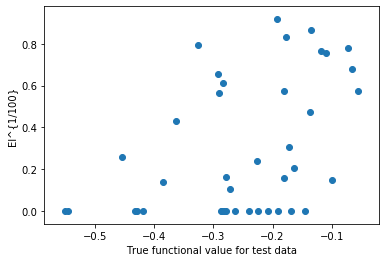

In [15]:
print(np.max(ei))
plt.scatter((test_y), np.power(ei,1/300))
plt.xlabel('True functional value for test data')
plt.ylabel('EI^{1/100}')
plt.show()